# Model comparison

In [1]:
import pyemma
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from glob import glob
import multiprocessing
from collections import Counter
import copy
import seaborn as sns
sns.set_style('ticks')
sns.set_context('talk')
from pathlib import Path
from typing import *
from dataclasses import dataclass 
import mdtraj as md

# NMM modules
import sys
sys.path.append('/Users/robertarbon/Software/NMpathAnalysis/nmpath')
from nmm import NonMarkovModel, MarkovPlusColorModel, DiscretePathEnsemble

## Auxiliary functions

In [2]:
@dataclass
class TPSStats:
    transition_paths: List[np.ndarray] # a list of transition paths
    prop_direct: List[float] # proportion of transition paths that are direct
    mean_length: List[float] # mean length of transition paths that are indirect
    state_prop: List[np.ndarray] # proportion of each indirect state on a transition path

    
@dataclass
class FSStats: 
    fundamental_sequences: List[Tuple[Tuple[int]]]
    weights: List[Tuple[float]]
    

In [72]:
def get_tps(trajs, ini_state, final_state, n_states, misfolded_state=[]):
    
    macro_dict = dict()
    for micro in ini_state:
        macro_dict[micro] = 0
    for micro in final_state:
        macro_dict[micro] = 2
    for micro in [x for x in range(n_states) if x not in ini_state+final_state]:
        macro_dict[micro] = 1
    
    tps_list=[]
    for traj in trajs:
        if isinstance(traj, np.ndarray): traj = traj.tolist()
        macro_traj = list(map(macro_dict.get, traj))
        tp=[]
        for i in range(0,len(macro_traj)):
            if macro_traj[i] == 0:
                tp = [traj[i]]
            elif macro_traj[i] == 2 and len(tp)>0:
                tp.append(traj[i])
                tps_list.append(np.array(tp))
                tp=[]
            elif len(tp)>0:
                tp.append(traj[i])
                
    if misfolded_state:
        tps_list_ = []
        for tps in tps_list:
            if not [microst for microst in tps if microst in misfolded_state]:
                tps_list_.append(tps)
        tps_list = tps_list_
                
    return(tps_list)

def _get_tps_stats(tps, stateA, stateB, n_states, misfolded_state=[]):
    
    # keep only intermediate fragments (of indirect paths) for counts
    tps_indir = np.array([path[1:-1] for path in tps if len(path) > 2])

    # pdirect
    pdirect = len([path for path in tps if len(path) == 2]) / len(tps)

    # mean path length (length of direct paths taken to be zero)
    mean_length = np.sum([len(path) for path in tps_indir]) / len(tps)
    if mean_length == 0: mean_length = np.nan

    # counts (indirect only)
    if len(tps_indir) == 0:
        print('There are no indirect TPs!')
        return pdirect, mean_length, np.nan
    tps_indir_concat = np.concatenate(tps_indir)
    counter = Counter(tps_indir_concat)
    counts = [counter[i] for i in [x for x in range(n_states) if x not in stateA+stateB+misfolded_state]]
    counts = np.array(counts) / len(tps_indir_concat)

    return pdirect, mean_length, counts

def get_tps_stats(tps, stateA, stateB, n_states, bootstrap=False, n_samples=1000, misfolded_state=[]):
    
    if len(tps) == 0:
        print('There are no TPs!')
        return np.nan, np.nan, np.nan

    if bootstrap:
        bootstrap_counts = []
        bootstrap_pdirect = []
        bootstrap_mean_length = []
        for bootstrap_ in range(n_samples):
            tps_ = np.random.choice(tps, len(tps))
            
            pdirect, mean_length, counts = _get_tps_stats(tps_, stateA, stateB, n_states, misfolded_state)
            
            bootstrap_pdirect.append(pdirect)
            bootstrap_mean_length.append(mean_length)
            bootstrap_counts.append(counts)

        return bootstrap_pdirect, bootstrap_mean_length, bootstrap_counts
            
    else:
        return _get_tps_stats(tps, stateA, stateB, n_states, misfolded_state)

def get_tps_w_stats(dtrajs: List[np.ndarray], stateA: np.ndarray, stateB: np.ndarray, 
                    n_states: int, bootstrap: bool = False, n_samples: int = 100, 
                    misfolded_state: List[int] = []) -> TPSStats:
    
    tps = get_tps(dtrajs, stateA, stateB, n_states, misfolded_state) + get_tps(dtrajs, stateB, stateA, n_states, misfolded_state)
    pdirect, mean_length, counts = get_tps_stats(tps, stateA, stateB, n_states, bootstrap, n_samples, misfolded_state)
    
    stats = TPSStats(transition_paths = tps, 
                     prop_direct = pdirect, 
                     mean_length = mean_length, 
                     state_prop = counts)
    
    return stats

def simulate_msm(msm, sim_traj_length=1000000):
    
    np.random.seed()
    traj = msm.simulate(sim_traj_length)
    
    return [traj]

def simulate_hamsm(nm_tmatrix, stateA, stateB, sim_traj_length=3000000):
    
    np.random.seed()
    sim = NonMarkovModel.from_nm_tmatrix(nm_tmatrix, stateA, stateB, sim_length=sim_traj_length, initial_state=stateA[0])
    trajs = sim.trajectories
    
    return trajs

def estimate_simulate_msm(dtrajs, lag, sim_traj_length=1000000):
    
    msm = pyemma.msm.estimate_markov_model(list(dtrajs), lag)
    trajs = simulate_msm(msm, sim_traj_length=sim_traj_length)
    
    return msm, trajs

def estimate_simulate_hamsm(dtrajs, stateA, stateB, hist_length='all', sim_traj_length=3000000):
    
    if hist_length == 'all':
        nm_model = NonMarkovModel(dtrajs, stateA, stateB, lag_time=1, clean_traj=True)
    else:
        nm_model = MarkovPlusColorModel(dtrajs, stateA, stateB, lag_time=1, hist_length=hist_length, clean_traj=True)
    
    trajs = simulate_hamsm(nm_model.nm_tmatrix, stateA, stateB, sim_traj_length)
    
    return nm_model, trajs

def coarsegrain_paths(tps, state_dict, stateA, stateB):

    tps_coarse = []

    for path in tps:
        if isinstance(path, np.ndarray): path = path.tolist()
        path_ = []
        for state in path:
            if state in stateA:
                path_.append(state_dict['A'])
            elif state in stateB:
                path_.append(state_dict['B'])
            else:
                path_.append(state_dict[state])
        if path_[0] == state_dict['B']:
            path_ = path_[::-1]
        tps_coarse.append(path_)
        
    return tps_coarse

def get_fundamental_sequences(tps, stateA, stateB, nm_dict, markov_tmatrix, bootstrap=False, n_samples=1000) -> FSStats:
    
    # keep only intermediate fragments (of indirect paths)
    tps_ = [path for path in tps if len(path) > 2]   
    tps_coarse = coarsegrain_paths(tps_, nm_dict, stateA, stateB)
    
    if bootstrap:
        bootstrap_FS = []
        bootstrap_FSweights = []
        for bootstrap in range(n_samples):
            tps_coarse_ = np.random.choice(tps_coarse, len(tps_coarse))
            
            ens = DiscretePathEnsemble(tps_coarse_, stateA=stateA, stateB=stateB)
            FS, FSweights, _ = ens.weighted_fundamental_sequences(markov_tmatrix)
            
            bootstrap_FS.append(FS)
            bootstrap_FSweights.append(FSweights)
        
        stats = FSStats(fundamental_sequences=bootstrap_FS, 
                        weights=bootstrap_FSweights)
        return stats
    
    else:
        ens = DiscretePathEnsemble(tps_coarse, stateA=stateA, stateB=stateB)
        FS, FSweights, _ = ens.weighted_fundamental_sequences(markov_tmatrix)
        
        stats = FSStats(fundamental_sequences=[FS], 
                        weights = [FSweights])
        
        return stats
    
def get_common_fundamental_sequences(FS, FSweights, FS_md_indexdict):
    
    FSweights_common = np.zeros(len(FS_md_indexdict))

    for j,seq in enumerate(FS):
        if seq in FS_md_indexdict:
            FSweights_common[FS_md_indexdict[seq]] = FSweights[j]
            
    return FSweights_common

def abs_error(x,y):
    abs_error = np.mean(np.abs(x-y))
        
    return abs_error



def state_definitions(dtrajs: List[np.ndarray], lag: int, frac_intermediate: float = 0.1, method: str = 'pcca') -> Tuple[np.ndarray, np.ndarray]: 
    msm = pyemma.msm.estimate_markov_model(dtrajs, lag)
    pcca = msm.pcca(2)

    # unfolded
    stateA_index = np.argmax([len(x) for x in pcca.metastable_sets])
    # folded
    stateB_index = np.argmin([len(x) for x in pcca.metastable_sets])

    cutoff = 0.5
    intermediate_len = 0
    while intermediate_len < frac_intermediate*msm.nstates:

        cutoff += 0.001 # adjust to make possible to get desired intermediate

        stateA = np.concatenate(np.argwhere(pcca.memberships[:,stateA_index] > cutoff)).tolist()
        stateB = np.concatenate(np.argwhere(pcca.memberships[:,stateB_index] > cutoff)).tolist()

        intermediate_len = msm.nstates - len(stateA) - len(stateB)  
    
    intermediate = [x for x in range(msm.nstates) if x not in stateA+stateB]
    
    print('Intermediate size: {}, cutoff: {}'.format(intermediate_len, cutoff))
    print('Unfolded size: {}, folded size: {}'.format(len(stateA), len(stateB)))

    return (stateA, stateB, intermediate)


def synthetic_trajectories(dtrajs: List[np.ndarray], lags: List[int], n_cores: int=8) -> List[np.ndarray]: 
    pool = multiprocessing.Pool(n_cores)
    out = pool.starmap(estimate_simulate_msm, [(dtrajs, lag) for lag in lags])
    pool.close()
    pool.join()

    msms = [x[0] for x in out]
    dtrajs_msms = [x[1] for x in out]
    del out
    
    return dtrajs_msms



def state_to_traj(dtrajs: List[np.ndarray], dtraj_paths: List[str], state: int, 
                  traj_dir: Path, top_path: str,  n_samples: int) -> md.Trajectory:
    count = 0
    indexes = []
    for i, dtraj in enumerate(dtrajs): 
        frames = np.where(dtraj==state)[0]
        if len(frames) > 0: 
            tmp = list(zip([i]*len(frames), frames))
            indexes.extend(tmp)

    
    samples_ix = np.random.choice(np.arange(len(indexes)), size=n_samples, replace=False)
    samples = [indexes[i] for i in samples_ix]
    
    def find_path(i): 
        p = list(traj_dir.rglob(f"{Path(dtraj_paths[i]).stem}*"))
        if len(p)>1: 
            raise ValueError('More than one trajectory found')
        return str(p[0])
        
    
    sample_paths = [(find_path(i), j) for i, j in samples]
    traj = md.join([md.load_frame(i, top=top_path, index=j) for i, j in sample_paths])
    traj = traj.superpose(traj)
    return traj
    
def save_transition_path(example_path: np.ndarray, dtrajs: List[np.ndarray], dtrajs_path: List[str], 
                         traj_dir: Path, top_path: str, n_samples: int, out_dir: Path) -> None: 
    
    out_dir.mkdir(exist_ok=True, parents=True)
    
    ix = [True]+list(example_path[:-1] - example_path[1:] != 0)
    no_reps_path = example_path[ix]
    for i, state in enumerate(no_reps_path): 
        traj = state_to_traj(dtrajs, dtraj_paths, state, traj_dir, top_path, n_samples)
        traj.save_pdb(str(out_dir.joinpath(f"step_{i}_state_{state}.pdb")))


def msm_remapped(dtrajs: List[np.ndarray], stateA: np.ndarray, stateB: np.ndarray, lag_time: int=1) -> Tuple[NonMarkovModel, Dict[Union[str, int], int]]: 
    dtrajs_ = copy.deepcopy(dtrajs) # coarse_macrostates = True modifies dtrajs
    nm_model = NonMarkovModel(dtrajs_, stateA, stateB, lag_time=lag_time, coarse_macrostates=True) 
    
    # make micro --> macro dictionary for path coarse-graining
    nm_dict = dict()
    nm_dict['A'] = nm_model.stateA[0]
    nm_dict['B'] = nm_model.stateB[0]

    for j in range(len(dtrajs)):
        for i in range(len(dtrajs[j])):
            if len(nm_dict) == nm_model.n_states:
                break
            if dtrajs[j][i] not in stateA+stateB:  
                nm_dict[dtrajs[j][i]] = nm_model.trajectories[j][i]

    return nm_model,  nm_dict



def common_fs(md_stats: FSStats, bs_md_stats: FSStats, msm_stats: List[FSStats]) -> Tuple[List[np.ndarray], List[np.ndarray]]:
    """
    Gets the sequences from bs_md_stats and msm_stats which appear in md_stats and retrieves their 
    """
    ix_by_seq = dict()
    for i,seq in enumerate(md_stats.fundamental_sequences[0]):
        ix_by_seq[seq] = i
    
    # MD
    n_bootstraps = len(bs_md_stats.fundamental_sequences)
    common_to_md = []
    for i in range(n_bootstraps): 
        weights = get_common_fundamental_sequences(bs_md_stats.fundamental_sequences[i], 
                                               bs_md_stats.weights[i], 
                                               ix_by_seq)
        assert len(ix_by_seq)==weights.shape[0]
        common_to_md.append(weights)
        
    # MSMs
    n_msms = len(msm_stats)
    common_to_msms = []
    for i in range(n_msms): 
        stats = msm_stats[i]
        weights = get_common_fundamental_sequences(stats.fundamental_sequences[0], 
                                               stats.weights[0], 
                                               ix_by_seq)
        assert len(ix_by_seq)==weights.shape[0]
        common_to_msms.append(weights)
        
    return common_to_md, common_to_msms



## Plotting functions

In [88]:

def plot_fs(fs_common_to_md: List[np.ndarray], fs_common_to_msms: List[np.ndarray], 
            lags: List[int], ax: matplotlib.axes.Axes,  md_kwargs: Dict, msm_kwargs: Dict) -> matplotlib.axes.Axes:
    
    delta_x = 0.05
    to_pc = 100
    
    n_lags = len(lags)
    n_fs_seqs = fs_common_to_md[0].shape[0]
    n_plot_fs = min(n_fs_seqs, 15)
    
    assert len(fs_common_to_msms) == n_lags
    
    cols = sns.color_palette('Reds', n_lags)
    
    y_md = np.mean(fs_common_to_md, axis=0)[:n_plot_fs]*to_pc
    lb = np.percentile(fs_common_to_md, 2.5, axis=0)[:n_plot_fs]*to_pc
    ub = np.percentile(fs_common_to_md, 97.5, axis=0)[:n_plot_fs]*to_pc
    yerr=[(y_md-lb),
          (ub-y_md)]
    
    fs_ix = np.arange(n_fs_seqs)
    for i in range(n_lags):
        x = fs_ix + i*delta_x
        y = fs_common_to_msms[i][:n_plot_fs]*to_pc - y_md
        ax.scatter(x, y, color=cols[i], **msm_kwargs, label=fr'$\tau$: {lags[i]} ns')
        
    ax.errorbar(fs_ix, np.zeros_like(y_md), yerr=yerr, label='MD (95% CI)', **md_kwargs)

    
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(int(n_plot_fs//10+1)))

    ax.grid()

    ax.set_xlabel('fundamental sequence')
    ax.set_ylabel('Err. p(FS$_\mathbf{ind}$) vs. MD (%)')
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.tight_layout()

    return ax

def plot_p_direct_by_def(md_stats_by_def: Dict[int, TPSStats], msm_stats_by_def: Dict[int, List[TPSStats]], 
                         state_defs: List[Tuple[List[int], List[int], List[int]]], lags: List[int], 
                         ax: matplotlib.axes.Axes,  md_kwargs: Dict, msm_kwargs: Dict) -> matplotlib.axes.Axes:

    n_state_defs = len(state_defs)
    n_lags = len(lags)
    to_pc = 100
    cols = sns.color_palette('Reds', n_lags)
    
    
    y_md = np.array([np.mean(md_stats_by_def[i].prop_direct) for i in range(n_state_defs)])*to_pc
    lb = np.array([np.percentile(md_stats_by_def[i].prop_direct, 2.5)*to_pc for i in range(n_state_defs)])
    ub = np.array([np.percentile(md_stats_by_def[i].prop_direct, 97.5)*to_pc for i in range(n_state_defs)])
    y_err = [(y_md-lb), 
              (ub-y_md)]
    
    int_lengths = [len(x[2]) for x in state_defs]

    for msm_ix in range(n_lags):
        y = np.array([msm_stats_by_def[k][msm_ix].prop_direct for k in range(n_state_defs)])*to_pc - y_md
        ax.scatter(int_lengths, y, color=cols[msm_ix], **msm_kwargs, label=fr'$\tau$: {lags[msm_ix]} ns')
        ax.plot(int_lengths, y,  color=cols[msm_ix], alpha=0.6)

    ax.errorbar(int_lengths, np.zeros_like(y_md), y_err, label='MD (95% CI)', **md_kwargs )

    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(int(n_state_defs//10+1)))

    ax.grid()

    ax.set_xlabel('intermediate microstates')
    ax.set_ylabel('Err. p(direct TP) vs. MD (%)')
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.tight_layout()

    return ax


    
    
def plot_state_prop_given_tp(md_stats: TPSStats, msm_stats: List[TPSStats], lags: List[int], 
                             ax: matplotlib.axes.Axes, md_kwargs: Dict, msm_kwargs: Dict) -> matplotlib.axes.Axes: 

    to_pc = 100
    
    delta_x = 0.05
    n_lags = len(lags)
    n_int_states = md_stats.state_prop[0].shape[0] # Number of intermediate states
    int_state_ix = np.arange(n_int_states)

    cols = sns.color_palette('Reds', n_lags)

    # eveythng is relative to mean of the MD
    y_md = np.mean(md_stats.state_prop, axis=0)*to_pc
    yerr_md = [y_md-np.percentile(md_stats.state_prop, 2.5, axis=0)*to_pc, 
               np.percentile(md_stats.state_prop, 97.5, axis=0)*to_pc-y_md]     


    for msm_ix in range(n_lags):
        y = msm_stats[msm_ix].state_prop*to_pc - y_md
        x = int_state_ix+delta_x*msm_ix
        ax.scatter(x, y, color=cols[msm_ix], label=fr'$\tau$: {lags[msm_ix]} ns', **msm_kwargs)

    ax.errorbar(int_state_ix, np.zeros_like(y_md), yerr_md, label='MD (95% CI)',
               **md_kwargs)
    
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(int(n_int_states//10+1)))

    ax.grid()

    ax.set_xlabel('intermediate microstate')
    ax.set_ylabel('Err. p(x|TP$_\mathrm{ind}$) vs. MD (%)')
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.tight_layout()
    
    return ax 

def plot_microstates(dtrajs: List[np.ndarray], x_ix: int, y_ix: int, example_path: np.ndarray, 
                     stateA: np.ndarray,stateB: np.ndarray, 
                     ax: matplotlib.axes.Axes) -> matplotlib.axes.Axes: 

    min_s = 50
    
    dtrajs_all = np.concatenate(dtrajs)
    
    vals, counts = np.unique(dtrajs_all, return_counts=True)
    probs = counts/counts.sum()
    F = -np.log(probs)
    F = F/np.min(F)*min_s

    cols = sns.color_palette('colorblind', 3)

    ax.scatter(ccs[np.array(stateA), x_ix], ccs[np.array(stateA),y_ix], color=cols[0], label='State A', 
               s=F[np.array(stateA)])
    ax.scatter(ccs[np.array(stateB), x_ix], ccs[np.array(stateB),y_ix], color=cols[1], label='State B', 
               s=F[np.array(stateB)])

    int_ix = np.array([x for x in range(n_states) if x not in stateA + stateB])
    ax.scatter(ccs[int_ix, x_ix], ccs[int_ix,y_ix], color=cols[2], label='Intermediate', s=F[int_ix])
    
    if example_path is not None:
        path_ix = np.array(example_path)
        ax.plot(ccs[path_ix, x_ix], ccs[path_ix, y_ix], color='k', label='Transition Path')
    
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    ax.set_ylabel(f"TICA {y_ix+1}")
    ax.set_xlabel(f"TICA {x_ix+1}")
    
    return ax



## Read MD data

In [5]:
root_dir = Path("/Users/robertarbon/Documents/Research/msm_sensitivity_analysis/data/msms")
# traj_dir = Path("/home/rob/Data/DESRES")

protein = '1fme'
system_name='BBA'
hp_ix = 53
lag = 41
lags = np.sort(np.array([1, 10, 100] + [lag]))
n_procs = 2

out_dir = Path(protein).joinpath(f'hp_{hp_ix}')
out_dir.mkdir(exist_ok=True, parents=True)

# top_path = list(traj_dir.rglob(f"*{protein.upper()}*/**/*.pdb"))[0]
# assert top_path

dtraj_paths = list(root_dir.joinpath(protein, 'dtrajs', f"hp_{hp_ix}").glob(f'*{protein.upper()}*.npy'))
dtrajs = [np.load(str(x)) for x in dtraj_paths]
ccs = np.load(root_dir.joinpath(protein, 'dtrajs', f"hp_{hp_ix}", 'cluster_centers.npy'))


dtrajs_all = np.concatenate(dtrajs)
n_states = np.unique(dtrajs_all).shape[0]

Get definitions of core states

In [6]:
stateA, stateB, intermediate = state_definitions(dtrajs=dtrajs, lag=lag)

Intermediate size: 3, cutoff: 0.8040000000000003
Unfolded size: 18, folded size: 2


In [7]:
stateA, stateB, intermediate

([0, 1, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15, 16, 19, 20, 21, 22],
 [7, 8],
 [2, 17, 18])

Generate synthetic trajectories from MSMs at different lag times

In [9]:
# synth_dtrajs = synthetic_trajectories(dtrajs, lags)
# np.save(out_dir.joinpath('synthetic_dtrajs.npy'), synth_dtrajs)
synth_dtrajs = np.load(out_dir.joinpath('synthetic_dtrajs.npy'))

# Mechanism plots

## 10% intermediates states

### p(x|TP) (indirect paths only)

In [11]:
md_stats = get_tps_w_stats(dtrajs, stateA, stateB, n_states=n_states, bootstrap=True)
msm_stats = [get_tps_w_stats(synth_dtraj, stateA, stateB, n_states=n_states) for synth_dtraj in synth_dtrajs]

/var/folders/b1/0b53wj0509376104__2tttb00000gn/T/ipykernel_32295/3204784368.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tps_ = np.random.choice(tps, len(tps))
/var/folders/b1/0b53wj0509376104__2tttb00000gn/T/ipykernel_32295/3204784368.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tps_indir = np.array([path[1:-1] for path in tps if len(path) > 2])


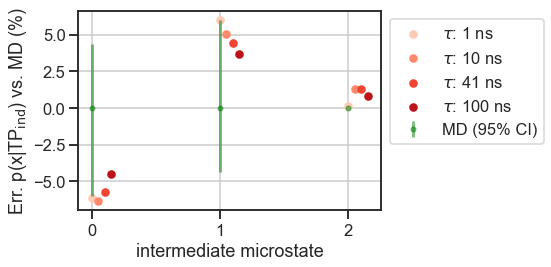

In [12]:

with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(8, 4))
    md_kwargs = dict(color='green',  fmt='o', elinewidth=3, alpha=0.5,  
                ms=5)
    msm_kwargs = dict(s=50)    
    ax = plot_state_prop_given_tp(md_stats, msm_stats, lags, ax,  md_kwargs, msm_kwargs)
    plt.savefig(out_dir.joinpath('p_X_TP.pdf'), bbox_inches='tight')
    plt.savefig(out_dir.joinpath('p_X_TP.png'), bbox_inches='tight', dpi=300)

### Example transition path

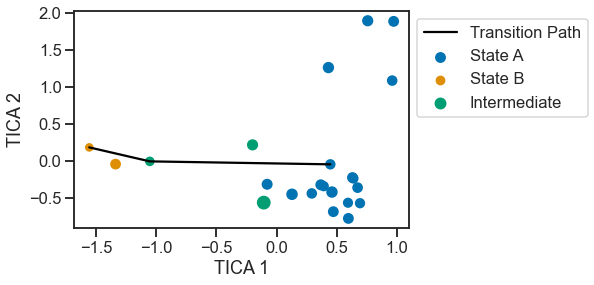

In [14]:
example_path = md_stats.transition_paths[3]

with sns.plotting_context('talk'): 
    fig, ax = plt.subplots()
    ax = plot_microstates(dtrajs, 0, 1, example_path, stateA, stateB, ax=ax)
    plt.savefig(out_dir.joinpath('example_path', 'tica_proj.png'), bbox_inches='tight')
    plt.savefig(out_dir.joinpath('example_path', 'tica_proj.pdf'), bbox_inches='tight')

#     save_transition_path(example_path, dtrajs, dtraj_paths, traj_dir, top_path, n_samples=10, out_dir=out_dir.joinpath('example_path'))

### Fundamental sequences (indirect paths only)

In [15]:
model, state_map = msm_remapped(dtrajs, stateA, stateB)

md_fs_stats = get_fundamental_sequences(md_stats.transition_paths, stateA, stateB, state_map, model.markov_tmatrix)

md_fs_stats_bs = get_fundamental_sequences(md_stats.transition_paths, stateA, stateB, state_map, model.markov_tmatrix, 
                                                                   bootstrap=True, n_samples=100)

msm_fs_stats = []
for i, msm_stat in enumerate(msm_stats):
    model.lag_time = lags[i]
    tmp  = get_fundamental_sequences(msm_stat.transition_paths, stateA, stateB, state_map, model.markov_tmatrix)
    msm_fs_stats.append(tmp)
model.lag_time = 1

fs_common_to_md, fs_common_to_msms = common_fs(md_fs_stats, md_fs_stats_bs, msm_fs_stats)


/var/folders/b1/0b53wj0509376104__2tttb00000gn/T/ipykernel_32295/3204784368.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tps_coarse_ = np.random.choice(tps_coarse, len(tps_coarse))


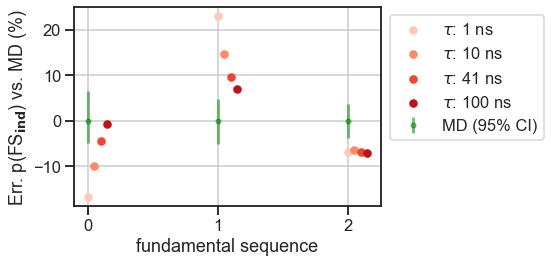

In [16]:
with sns.plotting_context('talk'): 
    fig, ax = plt.subplots(figsize=(8, 4))
    plot_fs(fs_common_to_md, fs_common_to_msms, lags, ax, md_kwargs, msm_kwargs)
plt.savefig(out_dir.joinpath('p_fs_ind.pdf'), bbox_inches='tight')
plt.savefig(out_dir.joinpath('p_fs_ind.png'), bbox_inches='tight', dpi=300)

## Multiple intermediate states

In [17]:
state_defs = [state_definitions(dtrajs, lag=lag, frac_intermediate=x) for x in np.arange(0.05, 0.8, 0.1)]

Intermediate size: 2, cutoff: 0.7770000000000002
Unfolded size: 19, folded size: 2
Intermediate size: 4, cutoff: 0.8070000000000003
Unfolded size: 17, folded size: 2
Intermediate size: 6, cutoff: 0.8560000000000003
Unfolded size: 15, folded size: 2
Intermediate size: 9, cutoff: 0.8770000000000003
Unfolded size: 12, folded size: 2
Intermediate size: 11, cutoff: 0.8850000000000003
Unfolded size: 10, folded size: 2
Intermediate size: 13, cutoff: 0.8880000000000003
Unfolded size: 8, folded size: 2
Intermediate size: 15, cutoff: 0.9000000000000004
Unfolded size: 6, folded size: 2
Intermediate size: 18, cutoff: 0.9040000000000004
Unfolded size: 4, folded size: 1


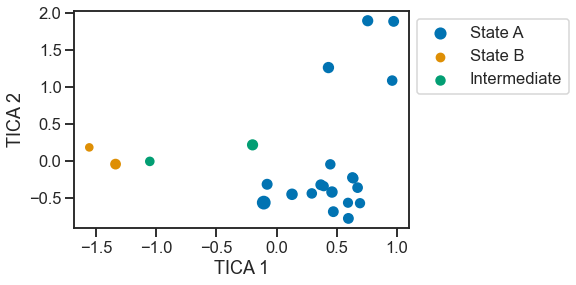

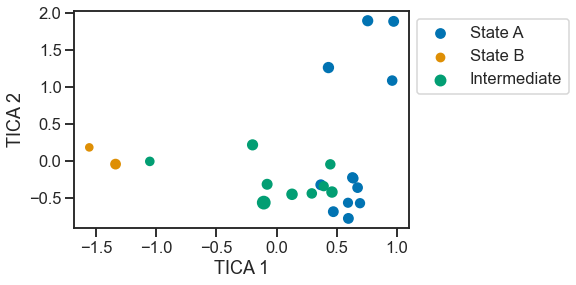

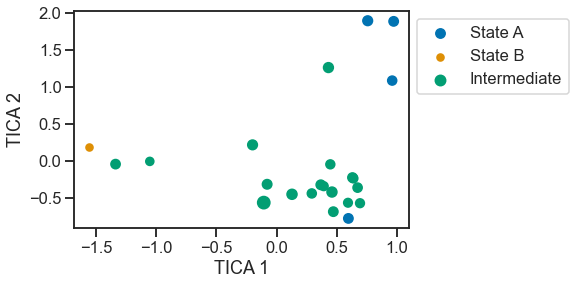

In [18]:
for i in [0, 3, len(state_defs)-1]: 
    with sns.plotting_context('talk'): 
        n_int = len(state_defs[i][2])
        
        fig, ax = plt.subplots()
        ax = plot_microstates(dtrajs, x_ix=0, y_ix=1, stateA = state_defs[i][0], 
                              stateB=state_defs[i][1], example_path=None,ax=ax) 
        plt.savefig(out_dir.joinpath('example_path', f"tica_proj_{n_int}.pdf"), bbox_inches='tight')
        plt.savefig(out_dir.joinpath('example_path', f"tica_proj_{n_int}.png"), bbox_inches='tight', dpi=300)
        

### p(direct TP)

In [19]:
md_stats_by_def = {k: get_tps_w_stats(dtrajs, state_defs[k][0], state_defs[k][1], n_states=n_states, bootstrap=True) 
                   for k in range(len(state_defs))}
                   
msm_stats_by_def = {k: [get_tps_w_stats(synth_dtraj, state_defs[k][0], state_defs[k][1], n_states=n_states) for synth_dtraj in synth_dtrajs]
                    for k in range(len(state_defs))}

/var/folders/b1/0b53wj0509376104__2tttb00000gn/T/ipykernel_32295/3204784368.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tps_ = np.random.choice(tps, len(tps))
/var/folders/b1/0b53wj0509376104__2tttb00000gn/T/ipykernel_32295/3204784368.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tps_indir = np.array([path[1:-1] for path in tps if len(path) > 2])


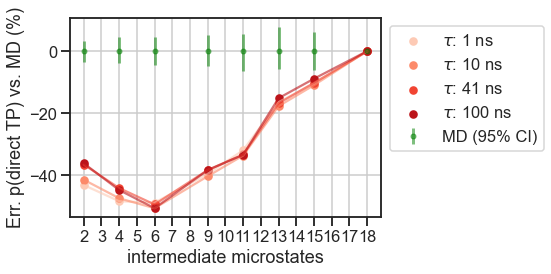

In [20]:
with sns.plotting_context('talk'): 
    fig, ax = plt.subplots(figsize=(8, 4))
    plot_p_direct_by_def(md_stats_by_def, msm_stats_by_def, state_defs, lags, ax, md_kwargs, msm_kwargs)
    plt.savefig(out_dir.joinpath('p_direct_by_def.pdf'), bbox_inches='tight')
    plt.savefig(out_dir.joinpath('p_direct_by_def.png'), bbox_inches='tight', dpi=300)

### p(x|TP) (indirect paths only)

[[4.68815367695254], [4.688153676952529]]
[[5.161815293764169], [5.323679490910143]]
[[7.365034933205649], [8.702151045897066]]
[[4.543385164218925], [5.08554415842397]]
[[4.825818548125461], [6.261920065195567]]
[[3.9482536549736733], [5.334274052097479]]
[[3.2205820477514844], [4.104610575656755]]
[[2.468893257719794], [2.9134215400016426]]


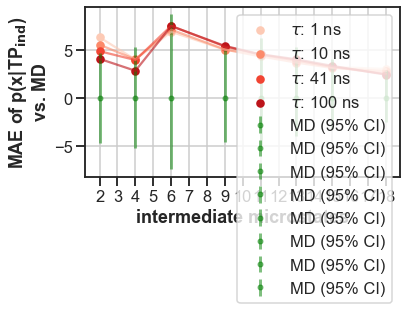

In [100]:
def plot_state_prop_given_tp_by_n_int(md_stats_by_def: Dict[int, TPSStats], 
                                     msm_stats_by_def: Dict[int, List[TPSStats]], 
                                     lags: List[int],  state_definitions: List[Tuple[np.ndarray]],
                                      ax: matplotlib.axes.Axes,  
                                     md_kwargs: Dict, msm_kwargs: Dict) -> matplotlib.axes.Axes:

    to_pc = 100    
    delta_x = 0.05
    n_lags = len(lags)
    cols = sns.color_palette('Reds', n_lags)
    state_def_ix = np.arange(len(state_definitions))
    n_state_defs = state_def_ix.shape[0]
    
    assert np.allclose(state_def_ix, np.sort(list(md_stats_by_def.keys())))
    
    # eveythng is relative to mean of the MD    
    len_int_states = np.array([len(state_definitions[i][2]) for i in state_def_ix])
    
    y_mds = [np.mean(md_stats_by_def[i].state_prop, axis=0)*to_pc for i in state_def_ix]

    for msm_index in range(n_lags):
        y = np.array([abs_error(msm_stats_by_def[i][msm_index].state_prop*to_pc,  y_mds[i]) for i in state_def_ix])
        x = len_int_states + msm_index*delta_x
        ax.scatter(len_int_states, y, color=cols[msm_index], **msm_kwargs, label=fr'$\tau$: {lags[msm_index]} ns')
        ax.plot(len_int_states, y, color=cols[msm_index], alpha=0.6)

    for i in state_def_ix:
        ys = y_mds[i]
        lbs = np.percentile(md_stats_by_def[i].state_prop, 2.5, axis=0)*to_pc
        ubs = np.percentile(md_stats_by_def[i].state_prop, 97.5, axis=0)*to_pc
        yerr=[[(np.mean(ys-lbs))],
              [(np.mean(ubs-ys))]]
        ax.errorbar(len_int_states[i], [0], yerr, label='MD (95% CI)',
                   **md_kwargs)
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(int(n_state_defs//10+1)))

    ax.grid()
    
    
    ax.set_xlabel('intermediate microstates', weight='bold')
    ax.set_ylabel('MAE of p(x|TP$_\mathbf{ind}$) \nvs. MD', weight='bold')
    plt.legend()
    plt.tight_layout()

with sns.plotting_context('talk'):
    fig, ax = plt.subplots()
    plot_state_prop_given_tp_by_n_int(md_stats_by_def, msm_stats_by_def, 
                                     lags, state_defs, ax, md_kwargs, msm_kwargs)
    plt.savefig(out_dir.joinpath('p_x_TP_by_def.pdf'), bbox_inches='tight')
    plt.savefig(out_dir.joinpath('p_x_TP_by_def.png'), bbox_inches='tight', dpi=300)

### mean TP length

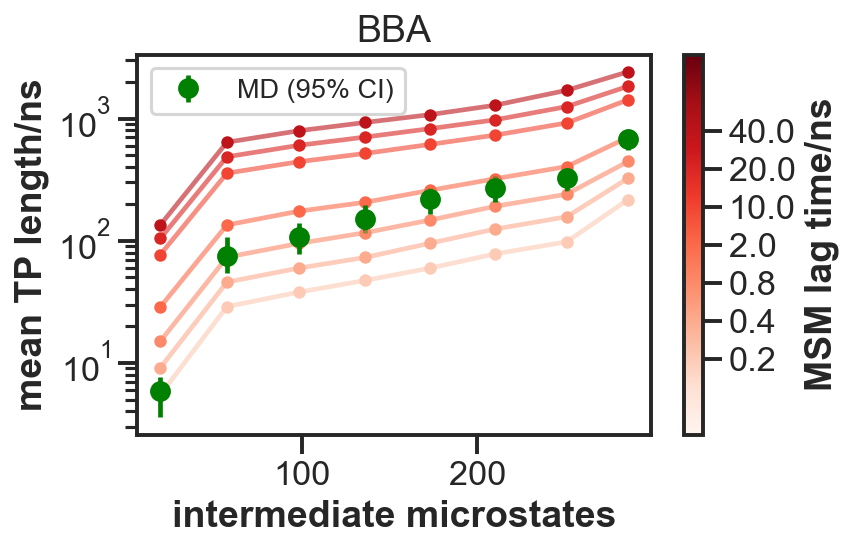

In [92]:
fig = plt.figure(dpi=150)
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(n_lags):
    y = np.array([i[msm_index] for i in length_msms_cutoffs])
    plt.scatter(intermediate_lens, y, s=20, color=cmap.to_rgba(msm_index))
    plt.plot(intermediate_lens, y, color=cmap.to_rgba(msm_index), alpha=0.6)

plt.errorbar(intermediate_lens, np.mean(length_md_cutoffs, axis=1), yerr=[(np.mean(length_md_cutoffs, axis=1)-np.percentile(length_md_cutoffs, 2.5, axis=1)), (np.percentile(length_md_cutoffs, 97.5, axis=1)-np.mean(length_md_cutoffs, axis=1))], color='green', label='MD (95% CI)', fmt='o')

# plt.scatter(intermediate_lens, length_hamsms_cutoffs, s=30, color='blue')
# plt.plot(intermediate_lens, length_hamsms_cutoffs, color='blue', label='haMSM (lag=0.2ns)')

cbar = plt.colorbar(cmap)
cbar.set_ticks(range(n_lags))
cbar.set_ticklabels(lags[:n_lags]*0.2)
cbar.set_label('MSM lag time/ns', weight='bold')

plt.xlabel('intermediate microstates', weight='bold')
plt.ylabel('mean TP length/ns', weight='bold')
plt.yscale('log')
# plt.xticks(range(0,100,25))
plt.title('{}'.format(system_name))
plt.legend(fontsize=13, loc='upper left')

plt.tight_layout()
plt.savefig('{}_TPlength_vsnomicrostates.pdf'.format(system_name))

plt.show()

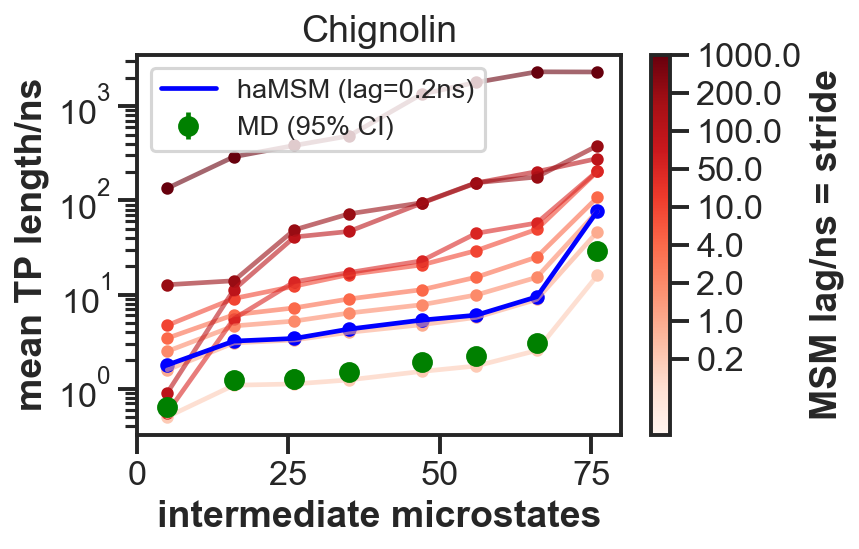

In [217]:
fig = plt.figure(dpi=150)
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    y = np.array([i[msm_index] for i in length_msms_cutoffs_strides])
    plt.scatter(intermediate_lens, y*0.2, s=20, color=cmap.to_rgba(msm_index))
    plt.plot(intermediate_lens, y*0.2, color=cmap.to_rgba(msm_index), alpha=0.6)

plt.errorbar(intermediate_lens, np.mean(length_md_cutoffs, axis=1)*0.2, yerr=[(np.mean(length_md_cutoffs, axis=1)-np.percentile(length_md_cutoffs, 2.5, axis=1))*0.2, (np.percentile(length_md_cutoffs, 97.5, axis=1)-np.mean(length_md_cutoffs, axis=1))*0.2], color='green', label='MD (95% CI)', fmt='o')

plt.scatter(intermediate_lens, length_hamsms_cutoffs, s=30, color='blue')
plt.plot(intermediate_lens, length_hamsms_cutoffs, color='blue', label='haMSM (lag=0.2ns)')

cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('MSM lag/ns = stride', weight='bold') 

plt.xlabel('intermediate microstates', weight='bold')
plt.ylabel('mean TP length/ns', weight='bold')
plt.yscale('log')
plt.xticks(range(0,100,25))
plt.title('{}'.format(system_name))
plt.legend(fontsize=13)

plt.tight_layout()
plt.savefig('{}_TPlength_vsnomicrostates_strideeqlag.pdf'.format(system_name))

plt.show()